# 데이터 설명

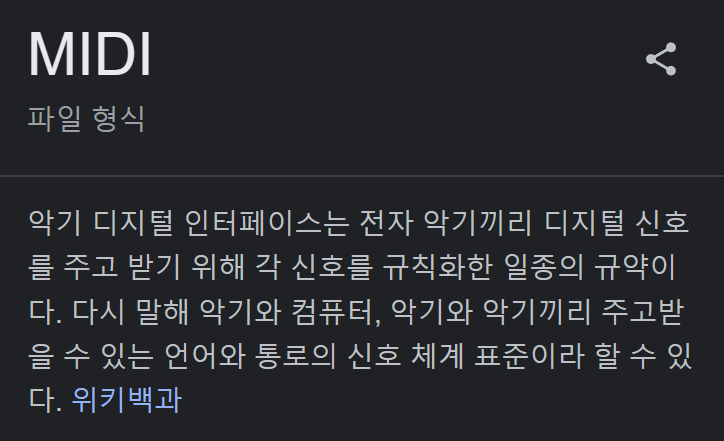

In [ ]:
#라이브러리 로드

# 배열 관련패키지
import numpy as np 
import pandas as pd 
from collections import Counter
import random

# 아이파이썬
import IPython
from IPython.display import Image, Audio

# 뮤직
import music21
from music21 import *

# 사이킷런, 텐서플로우 관련 패키지
from sklearn.model_selection import train_test_split
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax

# 시각화 관련
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys

# 그외 + 경고 무시
from  tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
import sys

In [ ]:
# !pip install keras

# 캐글 json으로 클래식 뮤직 midi 불러오기
from google.colab import files
!pip install -q kaggle #kaggle 설치 # --quiet
# -- kaggle api를 사용하기 위한 인증파일을 설정 (8-11)
files.upload() #kaggle API file upload
!mkdir ~/.kaggle # kaggle 디렉토리 생성 / mkdir : make directory - 폴더 생성 (~)
!cp kaggle.json ~/.kaggle/ #kaggle.json 파일 kaggle 폴더에 복사 / cp a b (copy)
!chmod 600 ~/.kaggle/kaggle.json # 권한 변경 r w x (4 2 1)
# ---------
# https://www.kaggle.com/datasets/soumikrakshit/classical-music-midi
!kaggle datasets download -d soumikrakshit/classical-music-midi

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/2.33M [00:00<?, ?B/s]
100% 2.33M/2.33M [00:00<00:00, 209MB/s]


In [ ]:
# 음악파일 압축 해제
!unzip /content/classical-music-midi.zip

Archive:  /content/classical-music-midi.zip
  inflating: albeniz/alb_esp1.mid    
  inflating: albeniz/alb_esp2.mid    
  inflating: albeniz/alb_esp3.mid    
  inflating: albeniz/alb_esp4.mid    
  inflating: albeniz/alb_esp5.mid    
  inflating: albeniz/alb_esp6.mid    
  inflating: albeniz/alb_se1.mid     
  inflating: albeniz/alb_se2.mid     
  inflating: albeniz/alb_se3.mid     
  inflating: albeniz/alb_se4.mid     
  inflating: albeniz/alb_se5.mid     
  inflating: albeniz/alb_se6.mid     
  inflating: albeniz/alb_se7.mid     
  inflating: albeniz/alb_se8.mid     
  inflating: bach/bach_846.mid       
  inflating: bach/bach_847.mid       
  inflating: bach/bach_850.mid       
  inflating: balakir/islamei.mid     
  inflating: beeth/appass_1.mid      
  inflating: beeth/appass_2.mid      
  inflating: beeth/appass_3.mid      
  inflating: beeth/beethoven_hammerklavier_1.mid  
  inflating: beeth/beethoven_hammerklavier_2.mid  
  inflating: beeth/beethoven_hammerklavier_3.mid  
  inf

In [ ]:
# 시드값
np.random.seed(1)



In [ ]:
# 쇼팽 곡부터 시작
filepath = "/content/chopin/"
# all midis에 mid 파일 저장
# 시간 주의
all_midis= []
for i in tqdm(os.listdir(filepath)):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)



12.2550 sec


# Corpus

* 현재 데이터셋에서는 corpus를 음계[C, D, E, F, G, A, B]로 사용합니다.
* 장조/ 단조 포함

In [ ]:
# 음계 추출용 함수      
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
# Corpus가 음계입니다
Corpus= extract_notes(all_midis)
print(f"- 모든 쇼팽 midi에 있는 노트 합계 : {len(Corpus)}")
print(f"- 음계의 앞부분 50개 확인: {Corpus[:50]}")

- 모든 쇼팽 midi에 있는 노트 합계 : 63429
음계의 앞부분 50개: ['E-3', 'C2', 'G3', 'G2', 'E-4', 'C3', 'E-4', 'C3', 'G4', 'G3', 'E-5', 'C4', 'E-5', 'C4', 'G5', 'G4', 'E-6', 'C5', 'G5', 'G4', 'E-5', 'C4', 'E-5', 'C4', 'G4', 'G3', 'E-4', 'C3', 'E-4', 'C3', 'G3', 'G2', 'D3', 'C2', 'G#3', 'F2', 'D4', 'C3', 'D4', 'C3', 'G#4', 'F3', 'D5', 'C4', 'D5', 'C4', 'G#5', 'F4', 'D6', 'C5']


# 어플리케이션 : lily pond 다운로드
 - https://www.kaggle.com/code/truthisneverlinear/artificial-tchaikovsky
 - 위에서 찾음
 - 클래식 악보 & 작곡 프로그램

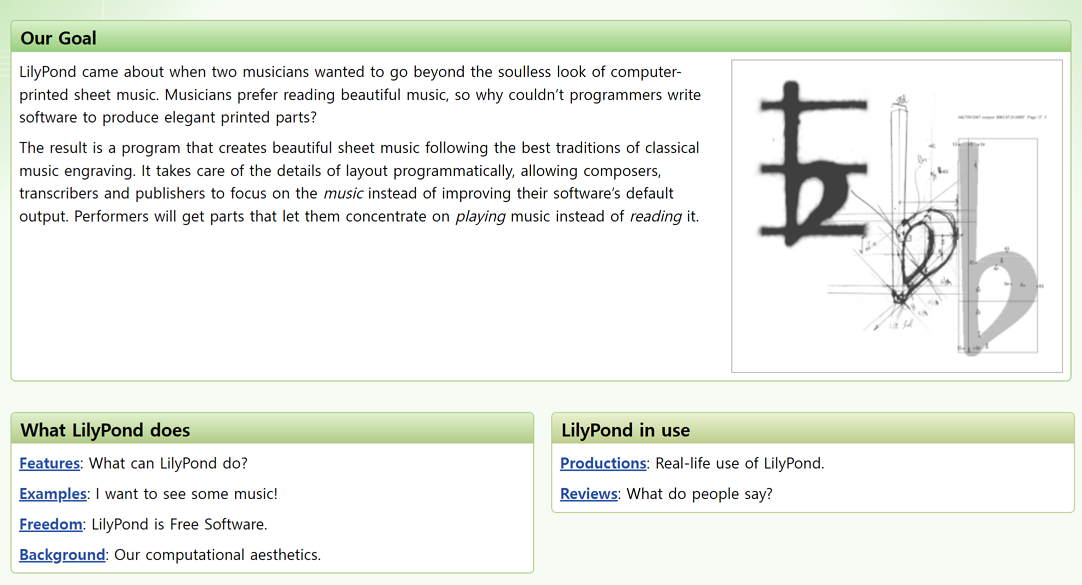

In [ ]:
# 프로그램 다운로드
!apt-get -y install lilypond -q

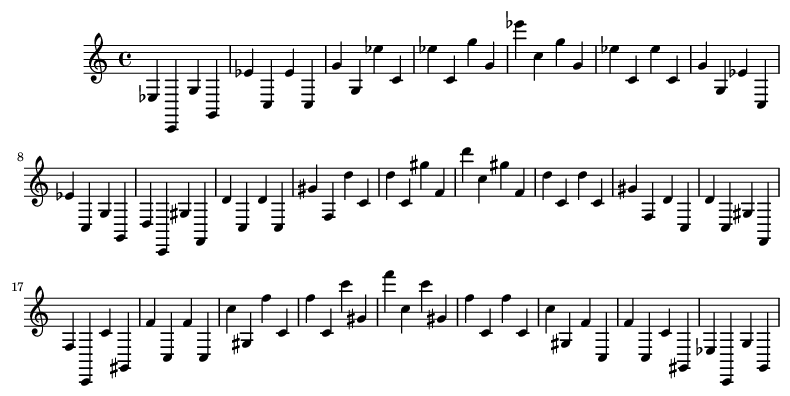

In [ ]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

In [ ]:
# 총 Corpus 확인
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 317


In [ ]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 200.09148264984228
Most frequent note in Corpus appeared: 1869 times
Least frequent note in Corpus appeared: 1 time


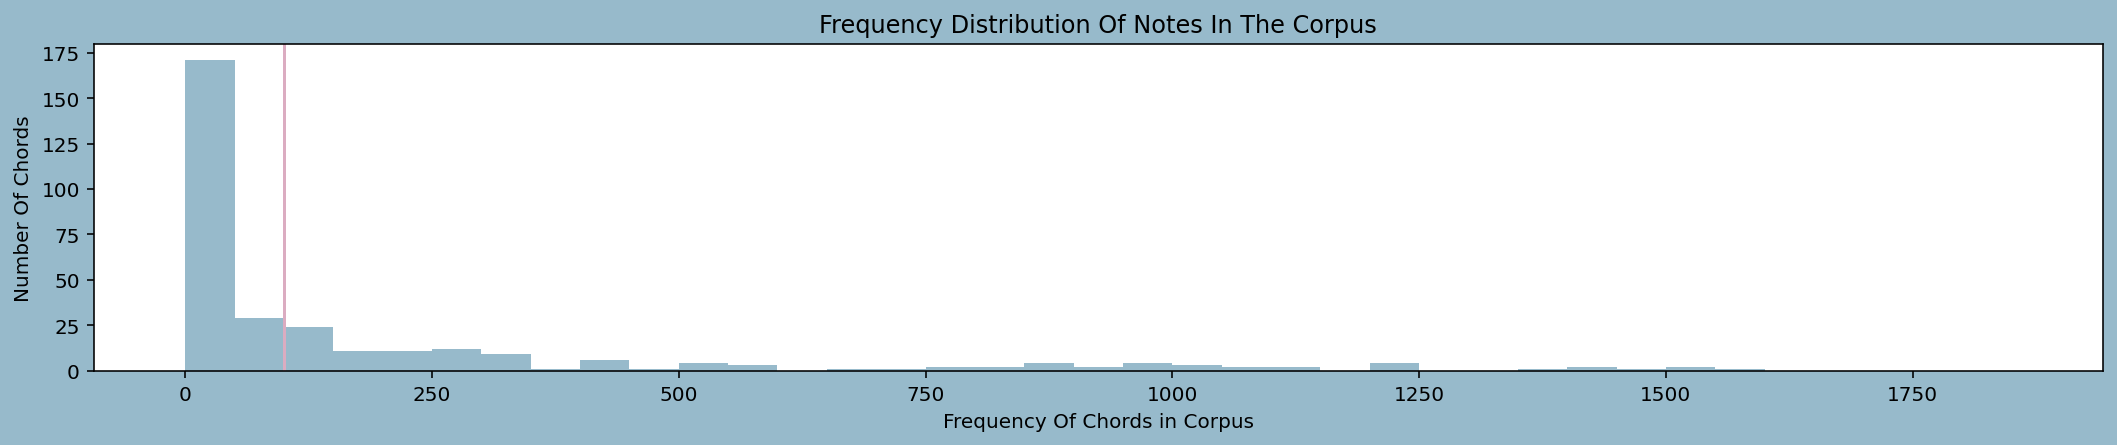

In [ ]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [ ]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 200


In [ ]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 59855


In [ ]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 59855
Number of unique characters: 229


In [ ]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 59815


TRAIN, TEST 데이터 나누기

In [ ]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [ ]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [ ]:
#Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 229)               58853     
                                                                 
Total params: 1,964,773
Trainable params: 1,964,773
Non-

# LSTM 신경망

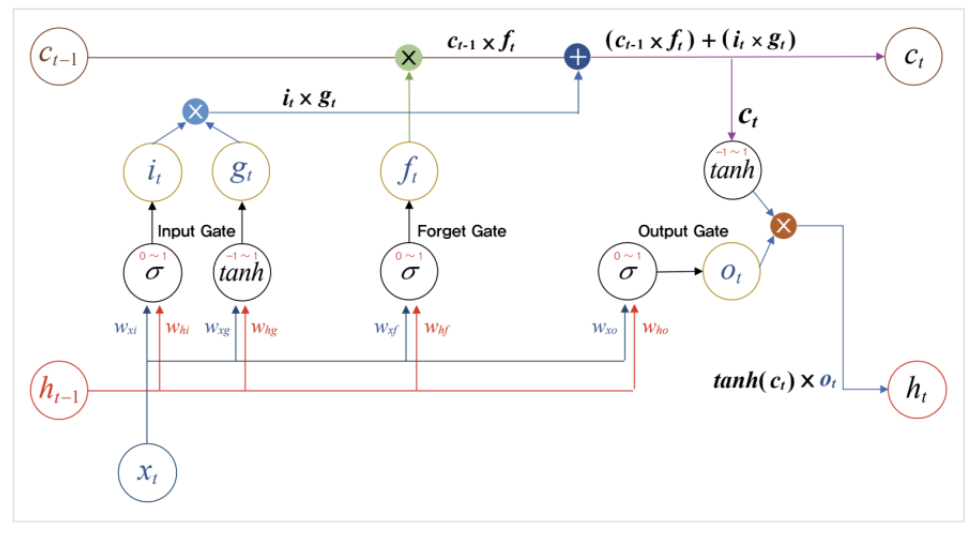

In [ ]:
#Training the Model
# 시간소요 : 13분
history = model.fit(X_train, y_train, batch_size=256, epochs=100)

Epoch 1/100
187/187 [==============================] - 17s 41ms/step - loss: 4.5626
Epoch 2/100
187/187 [==============================] - 8s 41ms/step - loss: 4.5088
Epoch 3/100
187/187 [==============================] - 8s 41ms/step - loss: 4.5067
Epoch 4/100
187/187 [==============================] - 8s 42ms/step - loss: 4.4952
Epoch 5/100
187/187 [==============================] - 9s 46ms/step - loss: 4.3558
Epoch 6/100
187/187 [==============================] - 8s 45ms/step - loss: 4.3258
Epoch 7/100
187/187 [==============================] - 8s 44ms/step - loss: 4.3029
Epoch 8/100
187/187 [==============================] - 8s 44ms/step - loss: 4.3080
Epoch 9/100
187/187 [==============================] - 8s 44ms/step - loss: 4.2922
Epoch 10/100
187/187 [==============================] - 8s 44ms/step - loss: 4.2883
Epoch 11/100
187/187 [==============================] - 8s 45ms/step - loss: 4.3984
Epoch 12/100
187/187 [==============================] - 8s 44ms/step - loss: 4.5126


[Text(0.5, 0, 'Epochs')]

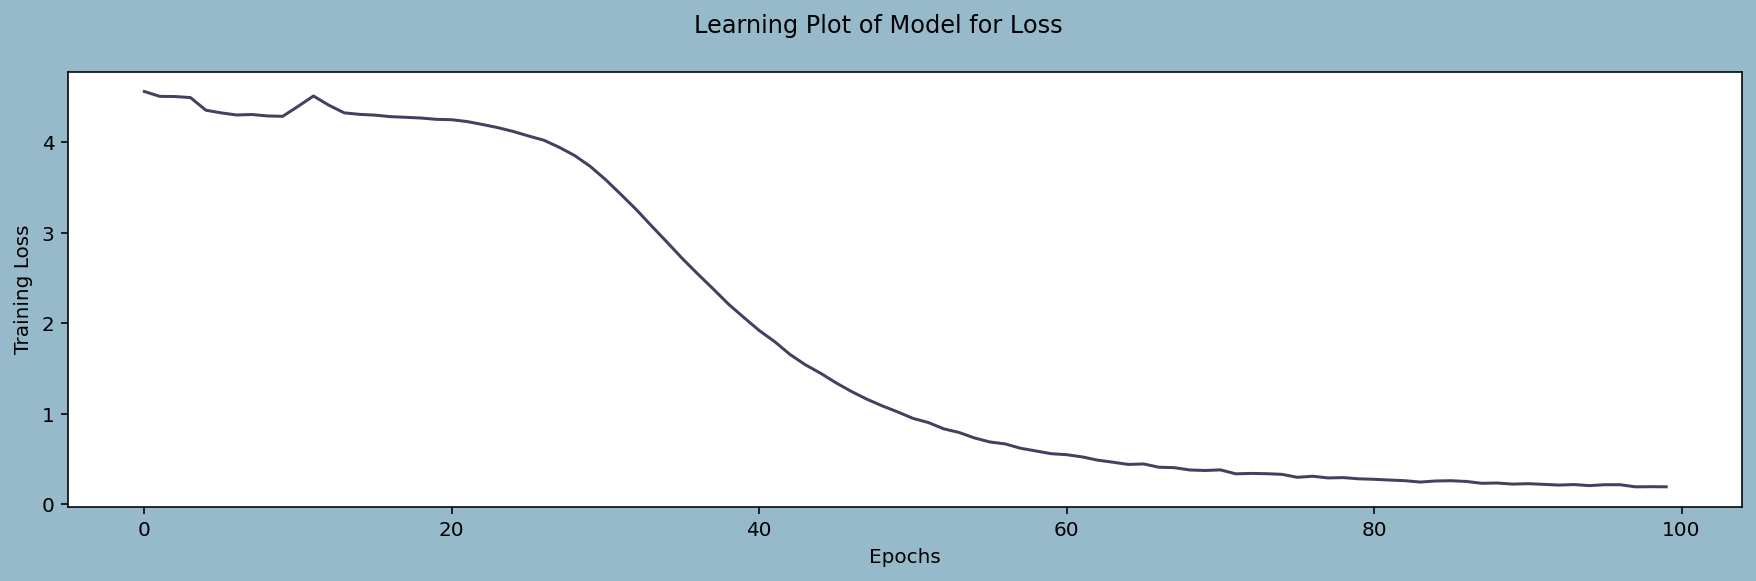

In [ ]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


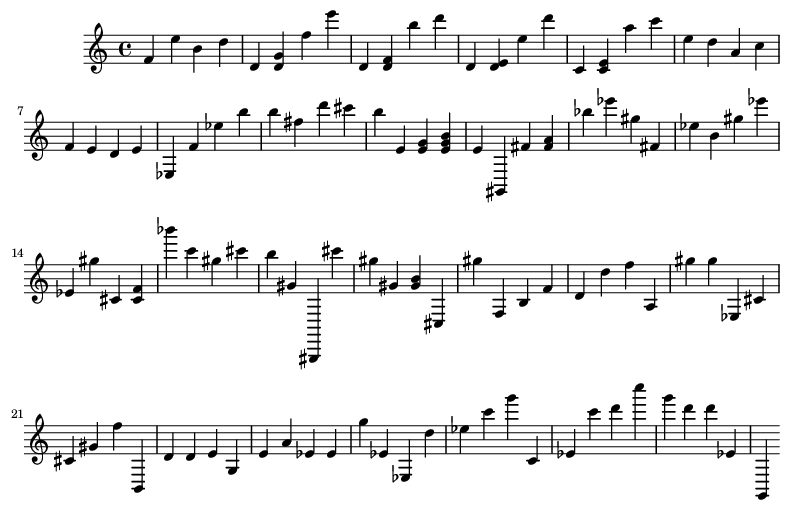

In [ ]:
from tqdm import tqdm
def Melody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in tqdm(range(Note_Count)):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Melody_Generator(100)
show(Melody)

In [ ]:
# 음계 확인
Music_notes

In [ ]:
#To save the generated melody
# Melody.write('midi','Melody_Generated.mid')
Melody.write('midi','Melody_Generated0.mid')
#to play audio or corpus
IPython.display.Audio("/content/Melody_Generated0.mid")



100%|██████████| 150/150 [00:06<00:00, 21.50it/s]


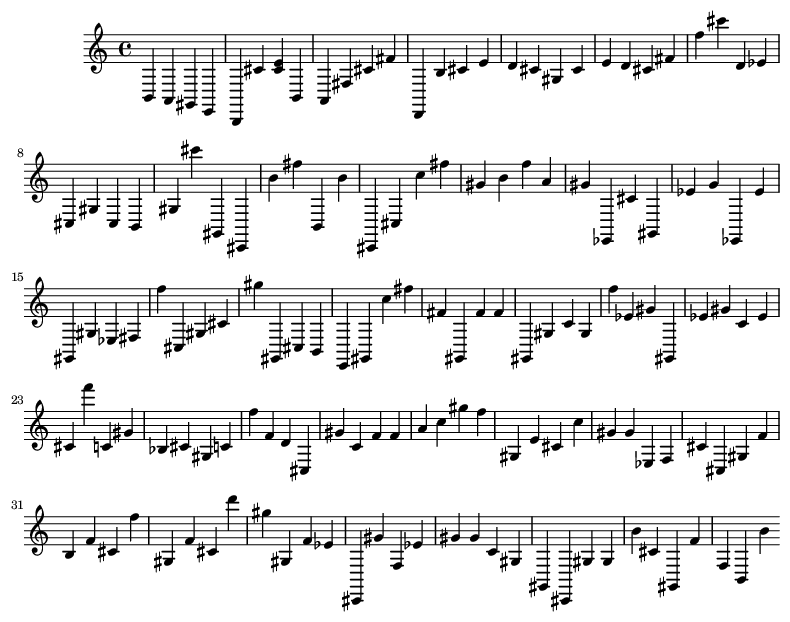

In [89]:
Music_notes, Melody = Melody_Generator(150)
show(Melody)

In [90]:
# 파일 다운로드 하기
Melody.write('midi','Melody_Generated150.mid')
files.download('Melody_Generated150.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 원작자 블로그

https://karnikakapoor.blogspot.com/2021/10/down-uncanny-valley.html

100%|██████████| 50/50 [00:02<00:00, 17.01it/s]


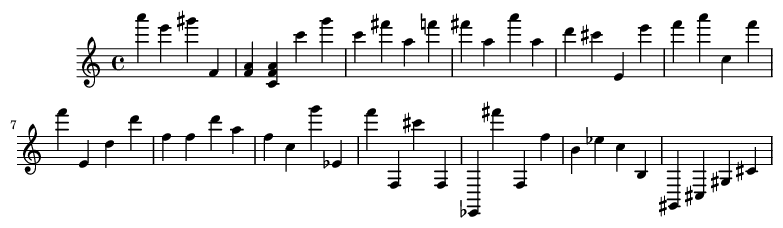

 50%|█████     | 1/2 [00:03<00:03,  3.58s/it]

/content/Melody_Generated50.mid



100%|██████████| 51/51 [00:02<00:00, 22.70it/s]


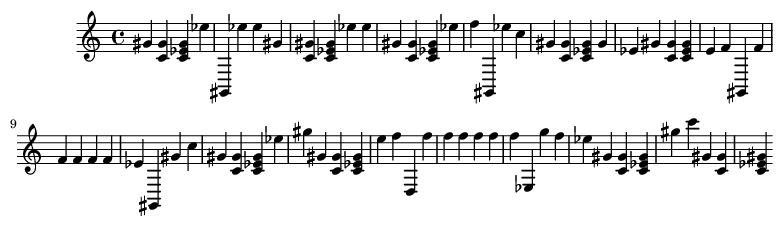

100%|██████████| 2/2 [00:06<00:00,  3.26s/it]

/content/Melody_Generated51.mid


In [ ]:
epochs = 50

for i in tqdm(range(epochs, epochs+2)):
    Music_notes, Melody = Melody_Generator(i)
    show(Melody)
    Melody.write('midi',f'Melody_Generated{i}.mid')
    IPython.display.Audio(f"/content/Melody_Generated{i}.mid")
    print(f"/content/Melody_Generated{i}.mid")

In [ ]:
# 파일 다운로드 하기
files.download(f'Melody_Generated{epochs}.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## 잠재 결론 : 150이상을 넘어가면 화음이 잘 쌓이지 않는다

# 지옥에서 돌아온 드뷔시

In [92]:
# 드뷔시 곡
filepath = "/content/debussy/"
# all midis에 mid 파일 저장
# 시간 주의
all_midis= []
for i in tqdm(os.listdir(filepath)):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

# 음계 추출용 함수      
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
# Corpus가 음계입니다
Corpus= extract_notes(all_midis)
print(f"- 모든 {filepath[9:]} midi에 있는 노트 합계 : {len(Corpus)}")
print(f"- 음계의 앞부분 50개 확인: {Corpus[:50]}")

100%|██████████| 9/9 [00:01<00:00,  7.07it/s]


- 모든 debussy/ midi에 있는 노트 합계 : 7647
- 음계의 앞부분 50개 확인: ['B-5', 'B-4', 'G#5', 'G#4', 'B-5', 'B-4', 'F5', 'F4', 'B-5', 'B-4', 'G#5', 'G#4', 'F5', 'F4', 'E-5', 'E-4', 'B4', 'B3', 'G#4', 'G#3', 'F4', 'F3', 'E-4', 'E-3', 'B3', 'B2', 'G#3', 'G#2', 'F3', 'F2', 'E-3', 'E-2', 'B2', 'B1', '2.7', '10', '10.3', '10.3', '5.7', '10.3', '10.3', '5.7', '10.3', '10.3', '10.3', '5.7', '10.3', '10.3', '5.7', '10.3']
